In [1]:
# option for size of picture output 
set_plot_dimensions <- function(width_choice=9, height_choice=5, res_choice=200) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice, repr.plot.res=res_choice)
        }
set_plot_dimensions()

**Material used for this lecture**

* Kéry, M., & Schaub, M. (2011). Bayesian population analysis using WinBUGS: a hierarchical perspective. Academic Press.
* Monneret, R. J., Ruffinoni, R., Parish, D., Pinaud, D., & Kéry, M. (2018). The Peregrine population study in the French Jura mountains 1964–2016: use of occupancy modeling to estimate population size and analyze site persistence and colonization rates. Ornis Hungarica, 26(2), 69-90.

# A simple model for Count Data 

We are going to use the peregrine 

In [2]:
library("ggplot2")
library("coda")
library("rjags")

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [3]:
# library("IPMbook")
# data(peregrine)
# write.csv(peregrine$count, file = "data/peregrine_count.csv", row.names = FALSE)
# write.csv(peregrine$productivity, file = "data/peregrine_productivity,.csv", row.names = FALSE)
# write.csv(peregrine$recoveries, file = "data/peregrine_recoveries.csv", row.names = FALSE)

### Peregrine falcon

We use data of [Peregrine flacon](https://en.wikipedia.org/wiki/Peregrine_falcon) used in Kéry and Schaub (2011).

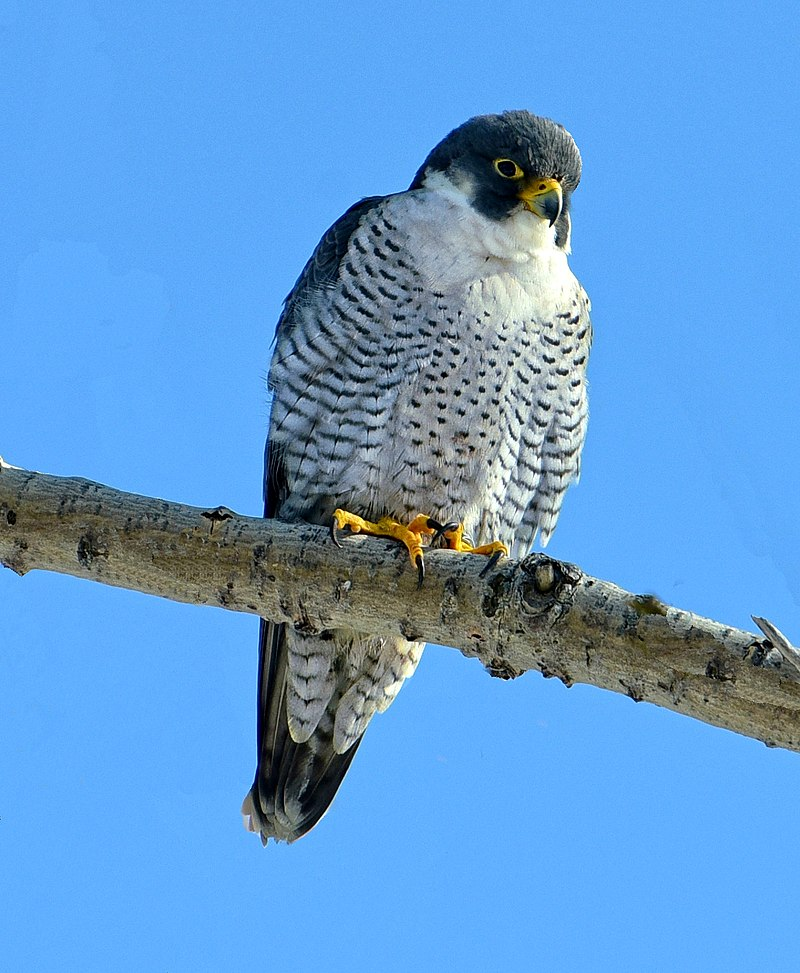

The data are collection of two ongoing peregrine population studies ; one located in the Swiss Jura mountains and in an adjacent region of the Swiss plateau, and the other in the French part of the Jura mountains.

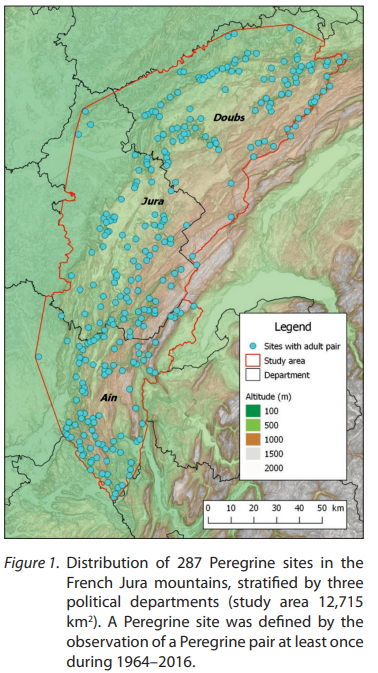

> **QUESTION**
>
> (1) - load the data in "data/peregrine_count.csv"
>
> (2) - plot the data

In [4]:
# REPLY (1) HERE


<details>
  <summary>ANSWER</summary>
 
  **copy/paste**

  ```R
  peregrine = read.table("data/peregrine_count.csv", sep = ",", header = TRUE)
  ```

</details>

In [5]:
# REPLY (2) HERE


<details>
  <summary>ANSWER</summary>
 
  **copy/paste**

  With basic R plot lib:

  ```R
  attach(peregrine)
  plot(Year, Breeding_pairs, xlab = "Year", ylab = "Pairs")
  ```

  With ggplot2 plot lib:

  ```R
    library("ggplot2")
    ggplot(data = peregrine) +
        theme_minimal() +
        labs(x = "Year", y = "Pairs") +
        geom_point(aes(x = Year, y = Breeding_pairs))
  ```

</details>

In [6]:
modelPeregrine <- "model
    {
        # Definition of links
        for (i in 1:n_data){
            Count[i] ~ dpois(lambda[i])
            log(lambda[i]) <- log.lambda[i]
            log.lambda[i] <- alpha + beta1 * Year[i] + beta2 * pow(Year[i], 2) + beta3 * pow(Year[i], 3)
        }
        # Definition priors
        alpha ~ dnorm(0,1/2)
        beta1 ~ dnorm(0,1/2) 
        beta2 ~ dnorm(0,1/2) 
        beta3 ~ dnorm(0,1/2) 
    }"

In [7]:
peregrine <- read.table("data/peregrine_count.csv", sep = ",", header = TRUE)
d_peregrine <- list(
    n_data = nrow(peregrine),
    Count = peregrine$Breeding_pairs,
    Year = peregrine$Year - min(peregrine$Year)
    )

In [8]:
jagsPeregrine <- jags.model(
    file = textConnection(modelPeregrine),
    data = d_peregrine,
    n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 43
   Unobserved stochastic nodes: 4
   Total graph size: 397

Initializing model



In [9]:
update(jagsPeregrine, 5000)

In [10]:
mcmc <- coda.samples(jagsPeregrine, c("alpha", "beta1", "beta2", "beta3"), n.iter = 10000)

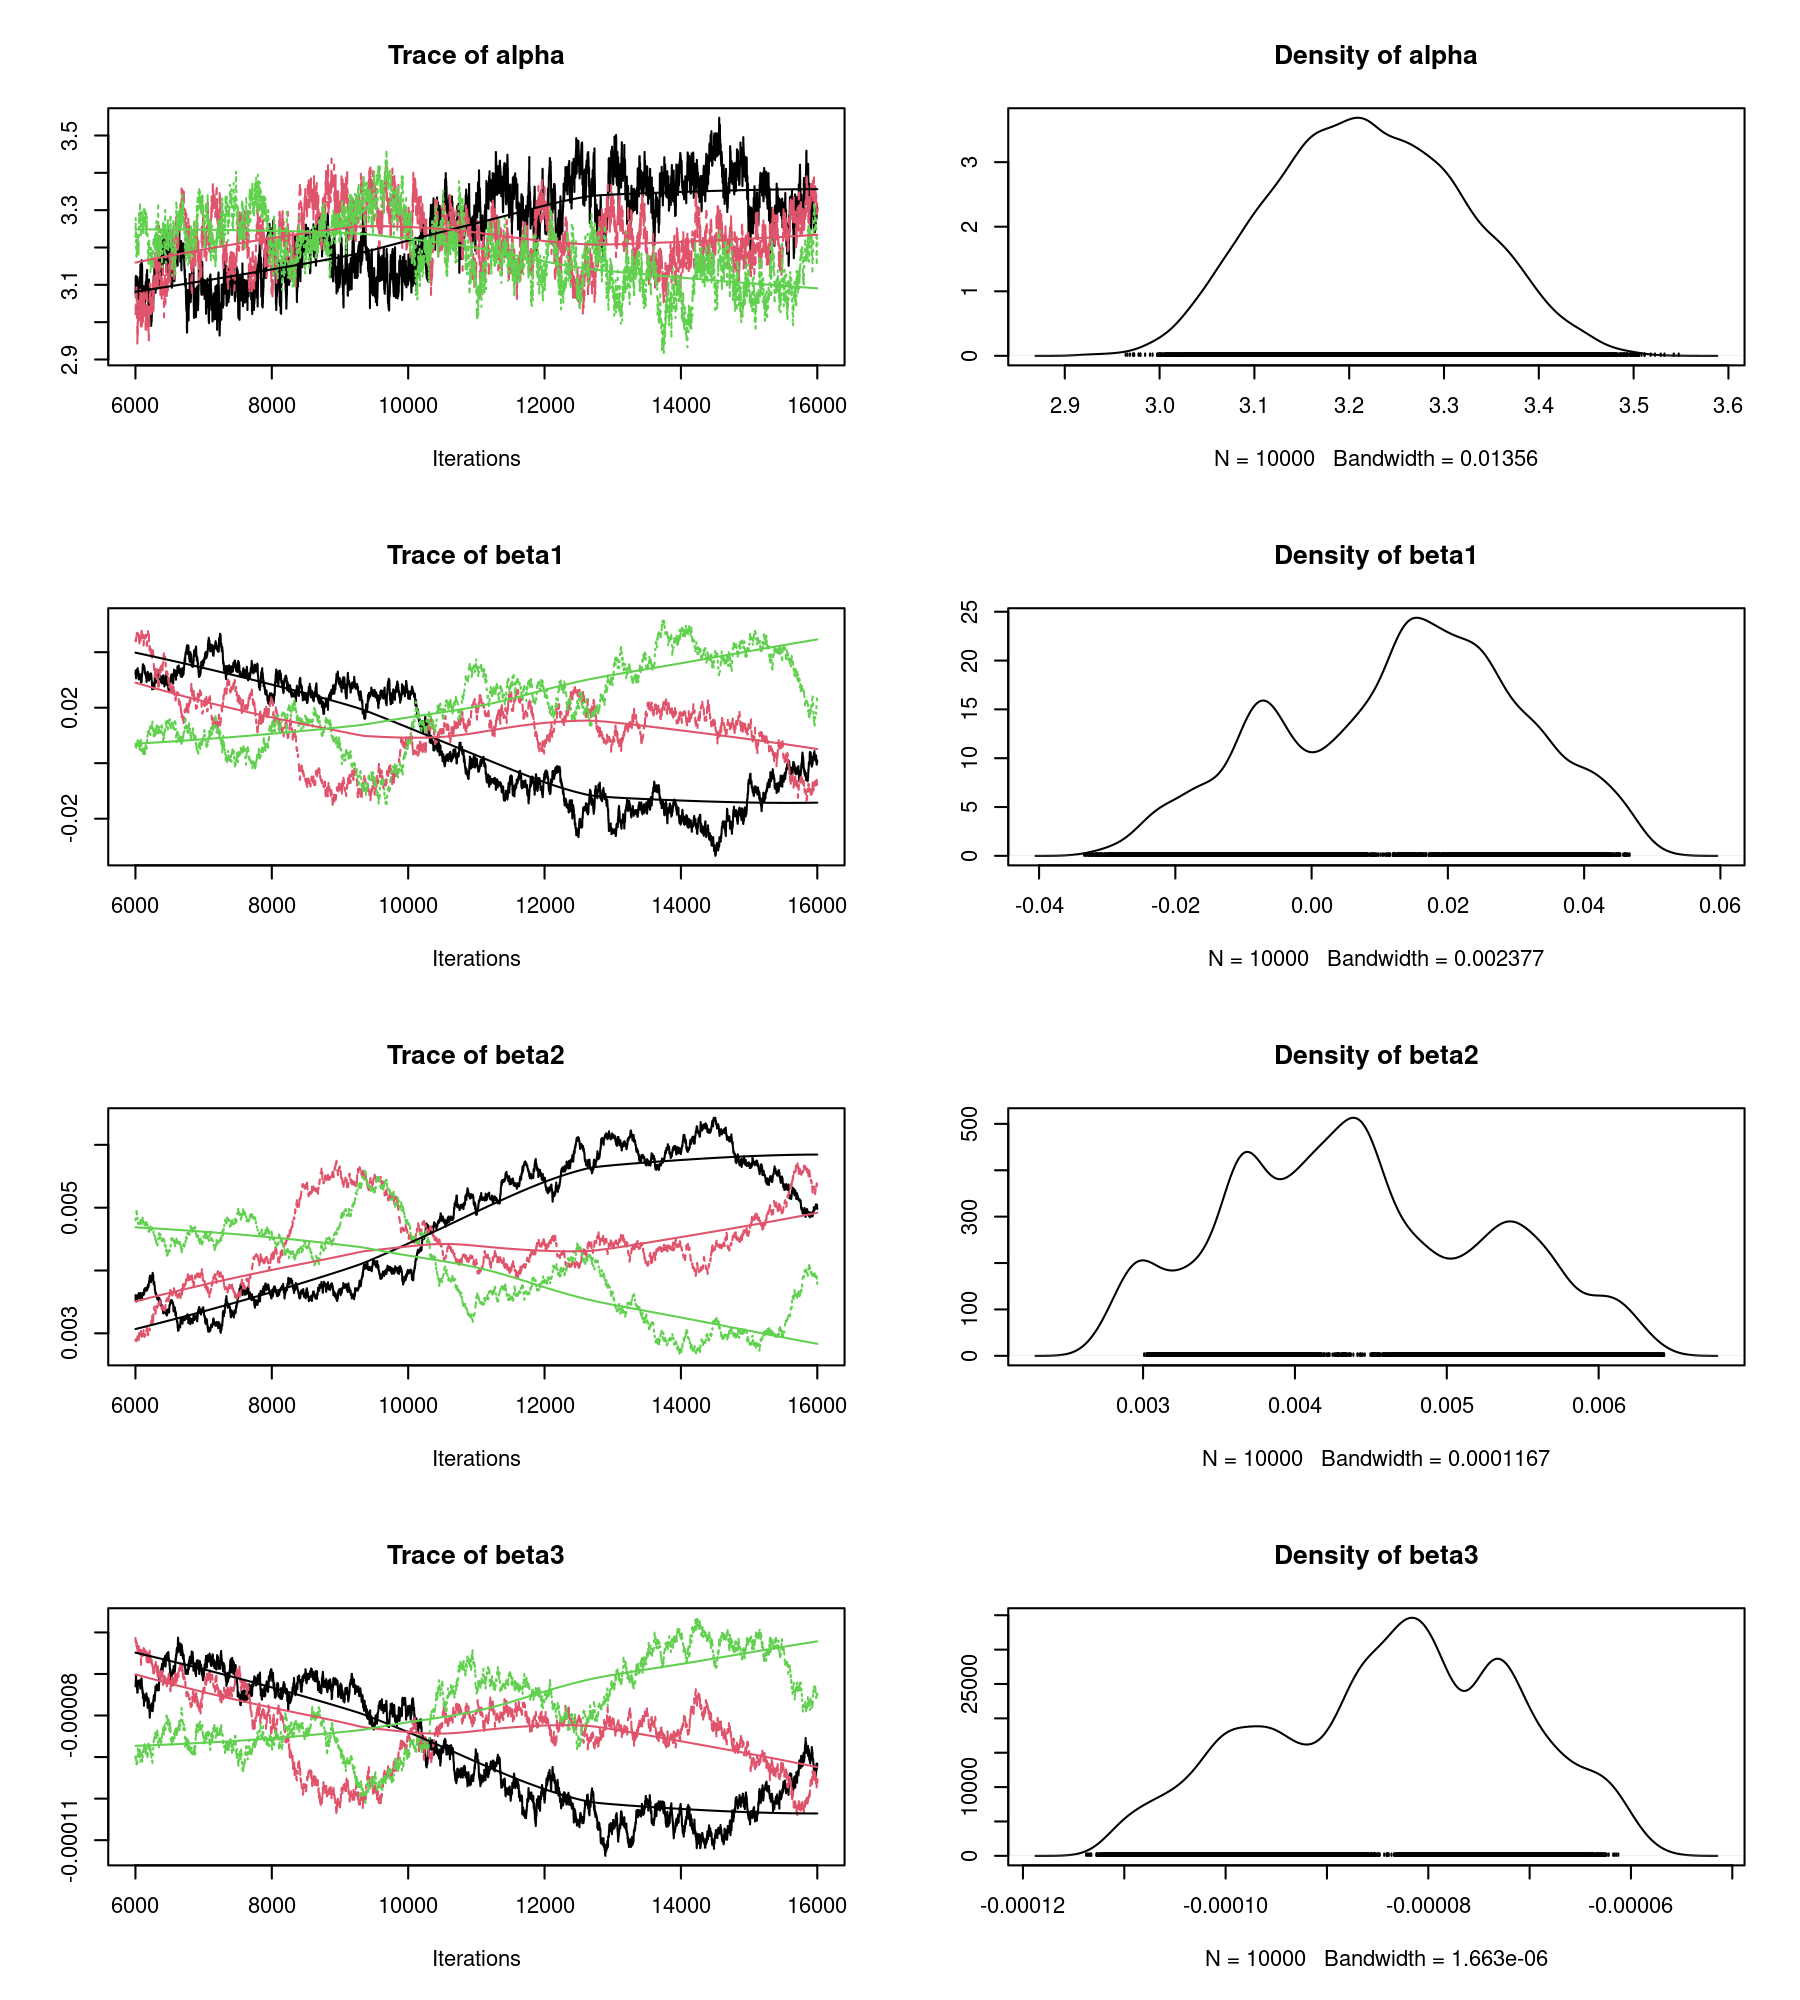

In [11]:
set_plot_dimensions(9,10)
plot(mcmc)

In [12]:
summary(mcmc)


Iterations = 6001:16000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean        SD  Naive SE Time-series SE
alpha  3.221e+00 1.006e-01 5.807e-04      1.232e-02
beta1  1.323e-02 1.763e-02 1.018e-04      5.779e-03
beta2  4.396e-03 8.655e-04 4.997e-06      4.117e-04
beta3 -8.348e-05 1.233e-05 7.121e-08      3.649e-06

2. Quantiles for each variable:

            2.5%        25%        50%        75%      97.5%
alpha  3.0366115  3.148e+00  3.2181023  3.293e+00  3.417e+00
beta1 -0.0217153 -5.336e-04  0.0149158  2.583e-02  4.442e-02
beta2  0.0029000  3.723e-03  0.0043350  5.061e-03  6.107e-03
beta3 -0.0001077 -9.291e-05 -0.0000825 -7.384e-05 -6.192e-05


In [13]:
means <- as.list(summary(mcmc)$statistics[, "Mean"])
years <- d_peregrine$Year

In [14]:
loglambda_mean <- means$alpha + means$beta1 * years + means$beta2 * years^2 + means$beta3 * years^3
lambda_mean <- exp(loglambda_mean)
Count <- sapply(lambda_mean, function(l) qpois(c(0.05,0.5,0.975),l))

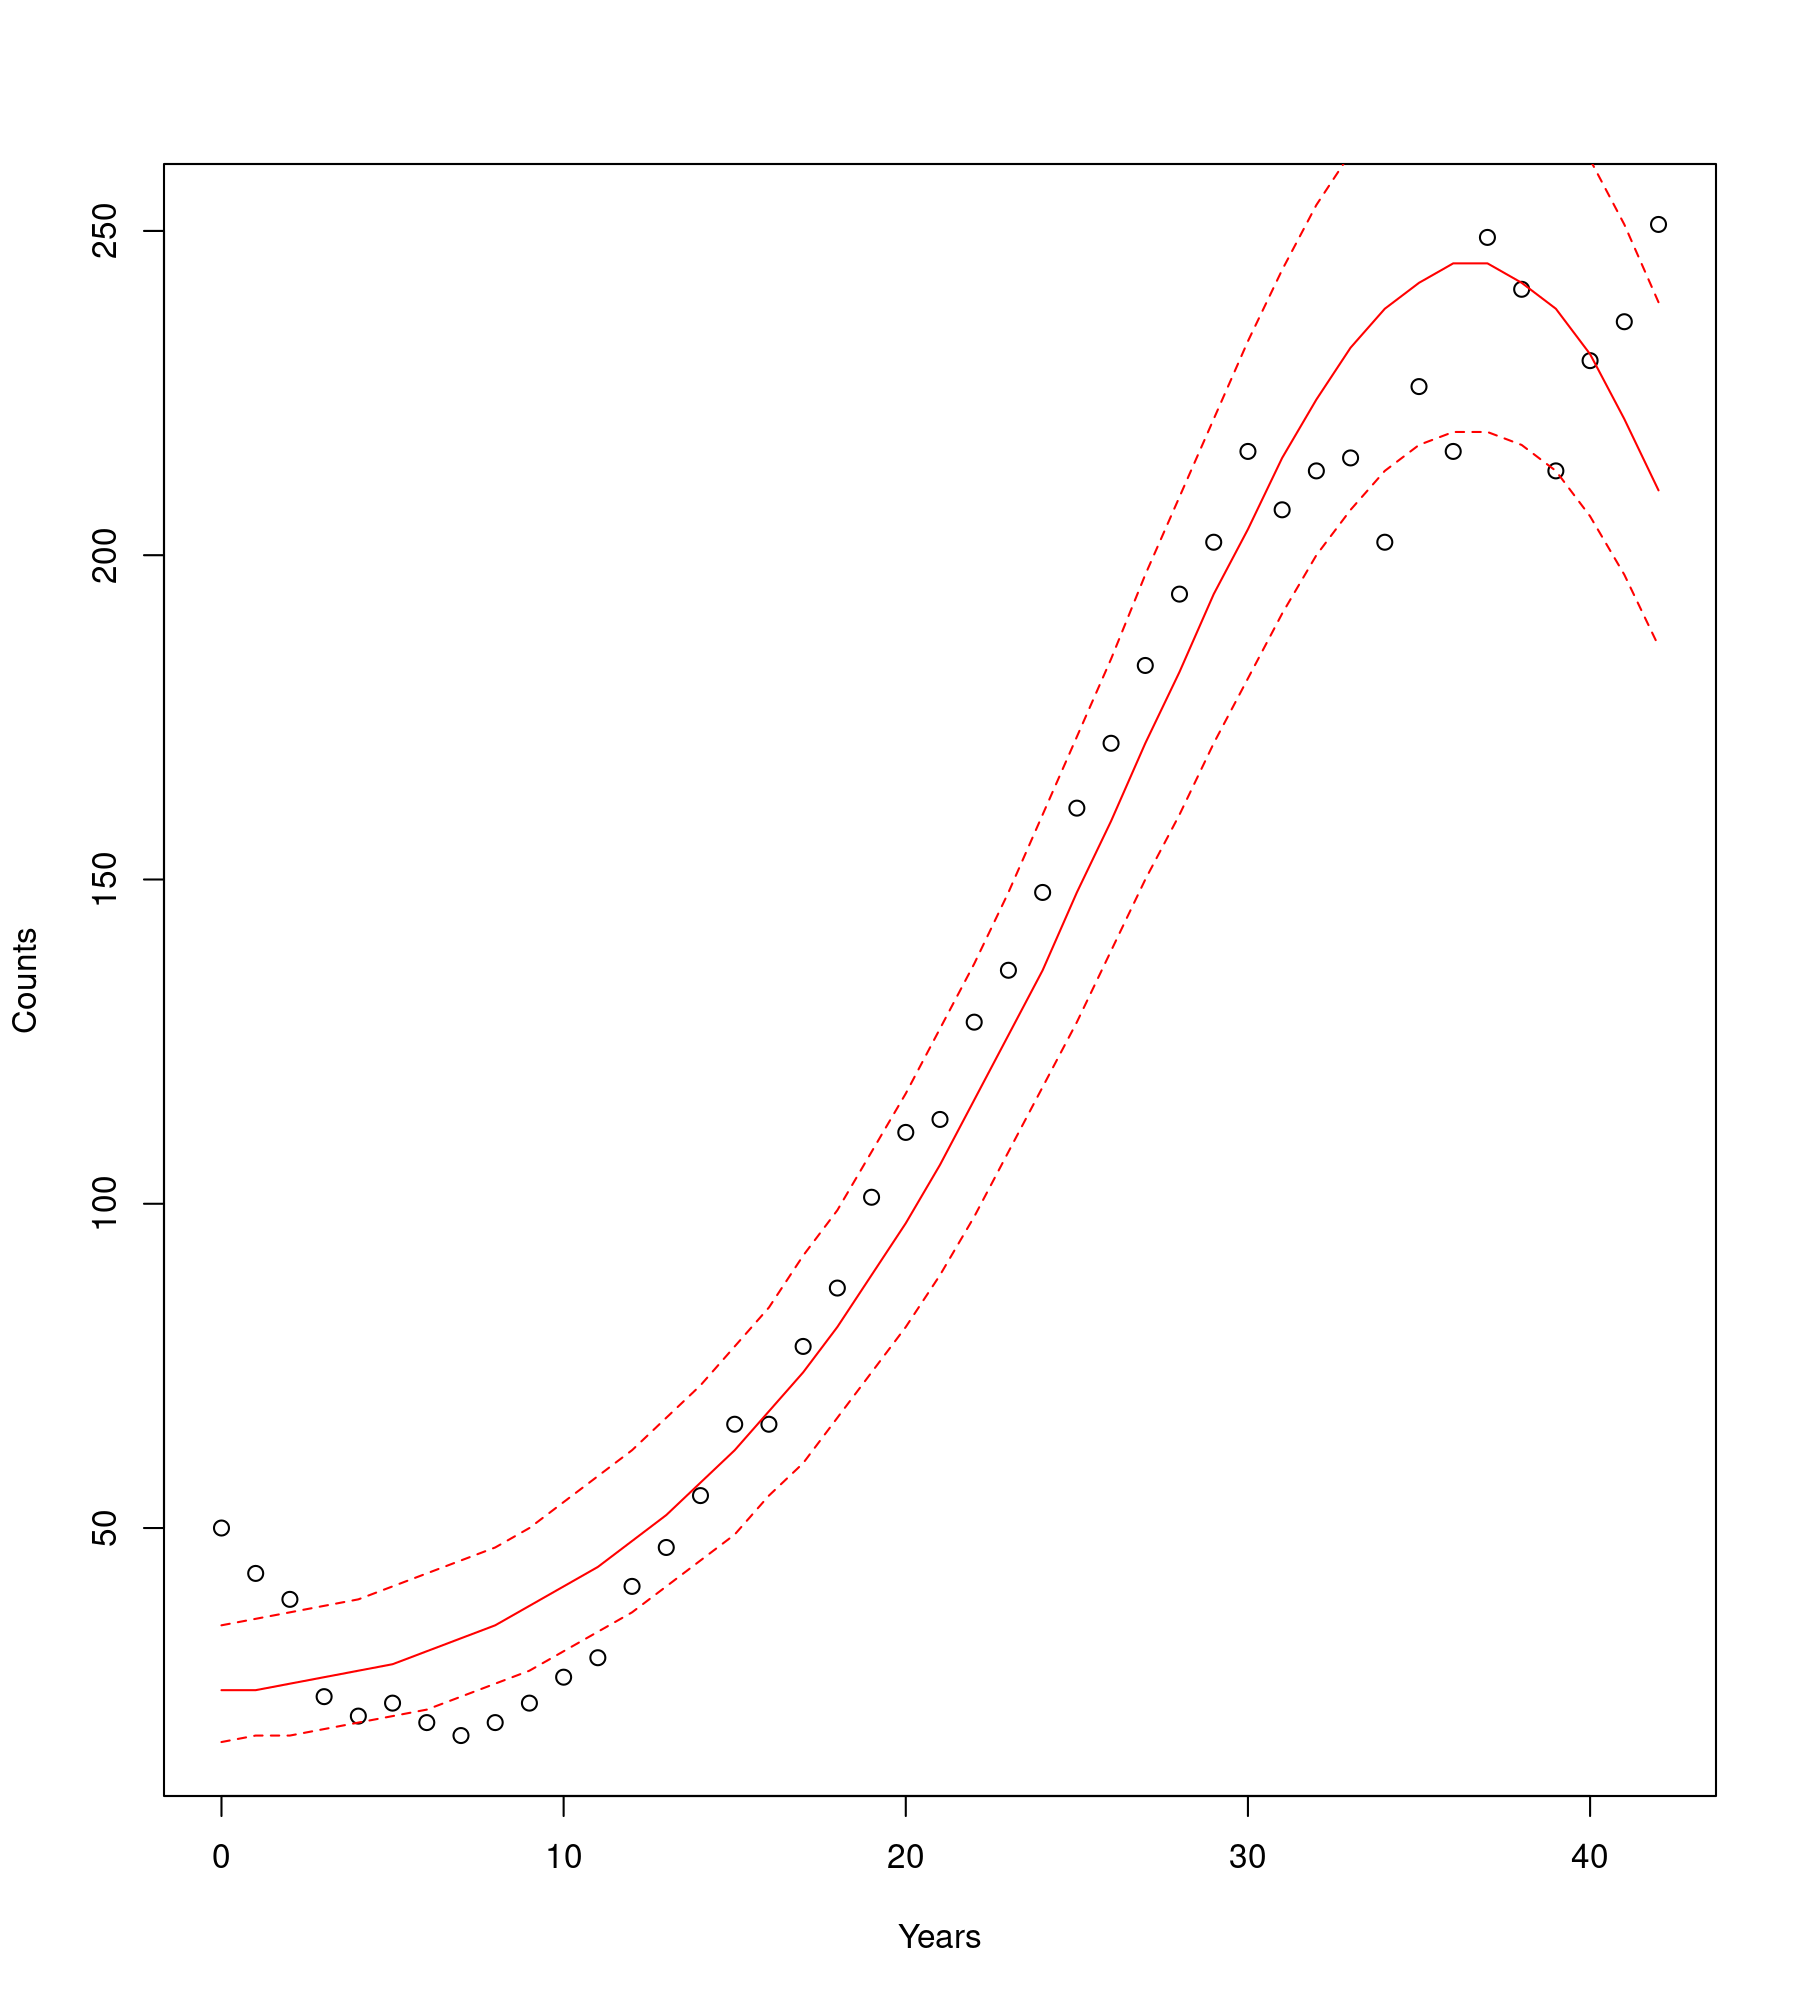

In [15]:
plot(years, d_peregrine$Count, xlab = "Years", ylab = "Counts")
lines(years, Count[2,], col = "red")
lines(years, Count[1,], col = "red", lty = 2)
lines(years, Count[3,], col = "red", lty = 2)

Using a Poisson law, the variance increase with the size of the population, hence the use of a log link function.

# Count data taking into account Time and Sites

Again, we use the data from Kery and Schaub (2011), now on the Coal tit (*Parus ater*) coming from the Swiss breeding bird survey, denoted MHB for "Monitoring Häufige Brutvögel" launched in 1999.

During each breeding season along 9 years, 235 1-km$^2$ quadrats are surveyed 2-3 times. 

1. Data Distribution:

The count number of individual at year $i$, site $j$, denoted $N_{i,j}$ follows the same Poisson law as for count data:

$$
N_{i,j} \sim \text{Poisson}(\lambda_{i,j})
$$

2. Link Function:

$$
\log(\lambda_{i,j}) = \alpha_j + \delta_i + \beta_1 \times \text{Year}_i + \beta_2 \times F_{i,j} + \gamma_{k,i,j}
$$

Where:

* $\alpha_j \sim \text{Normal}$: random site effects
* $\delta_i \sim \text{Normal}$: random year effects
* $\gamma_{k,i,j} \sim \text{Normal}$: random observer effects

It's an exponential model. We can assume that $lambda_t$ follow a Normal law:

$$
\lambda_t \sim \text{normal}(\bar{\lambda}, \sigma_{\lambda}^2)
$$

## Load Data

In [16]:
tits <- read.table(file="data/tits.txt", header = TRUE)

In [17]:
Counts = as.matrix(tits[5:13])
Observation = as.matrix(tits[14:22])
First_Obs = as.matrix(tits[23:31])

> **QUESTIONS**
>
> (3) - Plot all counts (y-axis) as function of years (x-axis)

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
    
  ```R
    matplot(1999:2007, t(Counts), type = "l", xlab = "Years", ylab = "Counts") 
  ```
</details>

## Simple Intercept-Only Model

We assume a constant expected count trhoughout space and time.

1. Data Distribution:

The count number of individual at year $i$, site $j$, denoted $N_{i,j}$ follows the same Poisson law as for count data:

$$
N_{i,j} \sim \text{Poisson}(\lambda_{i,j})
$$

2. Link Function:

$$
\log(\lambda_{i,j}) = \alpha 
$$

Where:

* $\alpha \sim \text{Normal}$: global intercept (no site specific)

In [18]:
GLM0 <- "model
    {
        # Definition of links
        for (i in 1:nyear){
            for(j in 1:nsite){
                Count[i,j] ~ dpois(lambda[i,j])
                log(lambda[i,j]) <- log.lambda[i,j]
                log.lambda[i,j] <- alpha 
            }
        }
        # Definition priors
        alpha ~ dnorm(0,0.01)
    }"

In [19]:
d_GLM0 <- list(
    Count = t(Counts),
    nsite = nrow(Counts),
    nyear = ncol(Counts)
)

In [20]:
jags_GLM0 <- jags.model(
    file = textConnection(GLM0),
    data = d_GLM0,
    n.chains = 3)
update(jags_GLM0, 5000)
mcmc_GLM0 <- coda.samples(jags_GLM0, c("alpha"), n.iter = 5000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2072
   Unobserved stochastic nodes: 44
   Total graph size: 2121

Initializing model



> **QUESTION**
>
> Using the next function to extract the variable $\alpha$. Plot a histogram of it.
>
> Add its mean, median and 95% CI.

In [21]:
extract_chain = function(mcmc, key, extend = FALSE){
    ls_mcmc = lapply(mcmc, function(m){
        matching_columns = grepl(key, colnames(m))
        return(m[,matching_columns])
    })
    if(extend == TRUE){
        matrix_key = do.call("rbind",ls_mcmc)
    } else{
        matrix_key = do.call("c",ls_mcmc)
    }
    return(matrix_key)
}

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
  ```R
alpha_GLM0 = extract_chain(mcmc_GLMO, "alpha")
hist(alpha_GLM0)
abline(v = mean(alpha_GLM0), col = "red")
abline(v = median(alpha_GLM0), col = "blue", lty = 2)
abline(v = quantile(alpha_GLM0, 0.025), col = "blue", lty = 3)
abline(v = quantile(alpha_GLM0, 0.975), col = "blue", lty = 3) 
  ```
</details>

> **QUESTION**
>
> (4) - Using the maplot function, add the prediction of the mode as an horizontal red line.
>

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
  ```R
matplot(1999:2007, t(Counts), type = "l", xlab = "Years", ylab = "Counts") 
abline(h = median(exp(alpha_GLM0)), col = "red", lwd = 3)  
  ```
</details>

## Fixed Site Effects Model

This model is like a one-way ANOVA, with a Poisson rather than Normal response, to compared sites.

1. Data Distribution:

The count number of individual at year $i$, site $j$, denoted $N_{i,j}$ follows the same Poisson law as for count data:

$$
N_{i,j} \sim \text{Poisson}(\lambda_{i,j})
$$

2. Link Function:

$$
\log(\lambda_{i,j}) = \alpha_j 
$$

Where:

* $\alpha_j \sim \text{Normal}$: random site effects

> **QUESTION**
>
> Make the modification in the previous model to obtain this new model

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
  ```R
GLM1 <- "model{
    # Definition of links
    for (i in 1:nyear){
        for(j in 1:nsite){
            Count[i,j] ~ dpois(lambda[i,j])
            log(lambda[i,j]) <- log.lambda[i,j]
            log.lambda[i,j] <- alpha[j] 
        }
    }
    # Definition priors
    for(j in 1:nsite){
        alpha[j] ~ dnorm(0,0.01)
    }
}"

  ```
</details>

In [22]:
GLM1 <- "model{
    # Definition of links
    for (i in 1:nyear){
        for(j in 1:nsite){
            Count[i,j] ~ dpois(lambda[i,j])
            log(lambda[i,j]) <- log.lambda[i,j]
            log.lambda[i,j] <- alpha[j] 
        }
    }
    # Definition priors
    for(j in 1:nsite){
        alpha[j] ~ dnorm(0,0.01)
    }
}"

In [23]:
d_GLM1 <- list(
    Count = t(Counts),
    nsite = nrow(Counts),
    nyear = ncol(Counts)
)

In [24]:
jags_GLM1 <- jags.model(
    file = textConnection(GLM1),
    data = d_GLM1,
    n.chains = 3)
update(jags_GLM1, 5000)
mcmc_GLM1 <- coda.samples(jags_GLM1, c("alpha"), n.iter = 5000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2072
   Unobserved stochastic nodes: 278
   Total graph size: 2589

Initializing model



In [25]:
alpha_GLM1 = extract_chain(mcmc_GLM1, "alpha", extend = TRUE)

We can then compute the mean of the $\lambda$ for each of the 235 sites:

In [26]:
lambda_GLM1_mean = apply(exp(alpha_GLM1), 2, mean)

> **QUESTION**
>
> (5) - Create a function to plot the data and curve for any site.

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
  ```R
plot_site_GLM1 <- function(site_num){
    matplot(1999:2007, Counts[site_num,], type = "l", xlab = "Years", ylab = "Counts") 
    abline(h = lambda_GLM1_mean[site_num], col = "blue", lwd = 3)
}
par(mfrow = c(4,4))
for(i in 1:16){
    plot_site_GLM1(i)
} 
  ```
</details>

## Fixed Site and Fixed Year Effect

This model is like a one-way ANOVA, with a Poisson rather than Normal response, to compared sites.

1. Data Distribution:

The count number of individual at year $i$, site $j$, denoted $N_{i,j}$ follows the same Poisson law as for count data:

$$
N_{i,j} \sim \text{Poisson}(\lambda_{i,j})
$$

2. Link Function:

$$
\log(\lambda_{i,j}) = \alpha_j + \delta_i  
$$

Where:

* $\alpha_j \sim \text{Normal}$: random site effects
* $\delta_i \sim \text{Normal}$: random year effects


In [27]:
GLM2 <- "model{
    # Definition of links
    for (i in 1:nyear){
        for(j in 1:nsite){
            Count[i,j] ~ dpois(lambda[i,j])
            log(lambda[i,j]) <- log.lambda[i,j]
            log.lambda[i,j] <- alpha[j] + delta[i]
        }
    }
    # Definition priors
    for(i in 1:nyear){
        delta[i] ~ dnorm(0,0.01)
    }
    for(j in 1:nsite){
        alpha[j] ~ dnorm(0,0.01)
    }
}"

In [28]:
d_GLM2 <- list(
    Count = t(Counts),
    nsite = nrow(Counts),
    nyear = ncol(Counts)
)

In [29]:
jags_GLM2 <- jags.model(
    file = textConnection(GLM2),
    data = d_GLM2,
    n.chains = 3)
update(jags_GLM2, 5000)
mcmc_GLM2 <- coda.samples(jags_GLM2, c("alpha", "delta"), n.iter = 5000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2072
   Unobserved stochastic nodes: 287
   Total graph size: 6593

Initializing model



> **QUESTION**
>
> (6) - Compare the quality of model using DIC

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
  ```R
# Compute DIC
# quite long to compute
n_iter = 5000
dic_GLM0 <- dic.samples(jags_GLM0, n.iter = n_iter)
dic_GLM1 <- dic.samples(jags_GLM1, n.iter = n_iter)
dic_GLM2 <- dic.samples(jags_GLM2, n.iter = n_iter)
print("dic_GLM0=")
dic_GLM0 
print("dic_GLM1=")
dic_GLM1
print("dic_GLM2=")
dic_GLM2 
  ```
</details>

> **QUESTION**
>
> (7) - Compute a matrix of lambda mean based on $\exp(\alpha_i + \delta_j)$

In [30]:
alpha_GLM2 = extract_chain(mcmc_GLM2, "alpha", extend=TRUE)
delta_GLM2 = extract_chain(mcmc_GLM2, "delta", extend=TRUE)

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
  ```R
lambda_GLM2 = matrix(NA,nrow = ncol(delta_GLM2), ncol = ncol(alpha_GLM2) )
for(i in 1:ncol(delta_GLM2)){
    for(j in 1:ncol(alpha_GLM2)){
        lambda_GLM2[i,j] = mean(exp(alpha_GLM2[j] + delta_GLM2[i]))
    }
} 
  ```
</details>

> **QUESTION**
>
> (8) - Write a function to have the plot of data and prediction for every site

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
  ```R
plot_site_GLM2 <- function(site_num){
    yval = c(lambda_GLM2[,site_num],Counts[site_num,])
    matplot(1999:2007, Counts[site_num,], type = "l", xlab = "Years", ylab = "Counts", ylim = c(min(yval, na.rm=TRUE), max(yval, na.rm=TRUE))) 
    lines(1999:2007, lambda_GLM2[,site_num], col = "blue", lwd = 3)
}
par(mfrow = c(4,4))
for(i in 1:16){
    plot_site_GLM2(i)
}
  ```
</details>

## Generalized Mixed Effect Model

### Random Site effect, Random year Effect

This model is like a one-way ANOVA, with a Poisson rather than Normal response, to compared sites.

1. Data Distribution:

The count number of individual at year $i$, site $j$, denoted $N_{i,j}$ follows the same Poisson law as for count data:

$$
N_{i,j} \sim \text{Poisson}(\lambda_{i,j})
$$

2. Link Function:

$$
\log(\lambda_{i,j}) = \alpha_j + \delta_i  
$$

Where:

* $\alpha_j \sim \text{Normal}$: random site effects
* $\delta_i \sim \text{Normal}$: random year effects

3. Random effect as a secondary level

$$
\alpha_j \sim \text{Normal}\left( 0, \sigma^2_{\alpha} \right) \quad , \, \sigma^2_{\alpha} \sim \text{Uniform}\left(0, 5 \right)
$$

$$
\delta_i \sim \text{Normal}\left( 0, \sigma^2_{\delta} \right) \quad , \, \sigma^2_{\delta} \sim \text{Uniform}\left(0, 3 \right)
$$

NOTE: In JAGS, the Normal function is define with the mean and the rate $\tau$ defines as the inverse of the variance $\tau = 1 / \sigma^2$.

In [31]:
GLMM <- "model{
    # Definition of links
    for (i in 1:nyear){
        for(j in 1:nsite){
            Count[i,j] ~ dpois(lambda[i,j])
            log(lambda[i,j]) <- log.lambda[i,j]
            log.lambda[i,j] <- alpha[j] + delta[i]
        }
    }
    # Definition priors
    for(i in 1:nyear){
        delta[i] ~ dnorm(0,0.01)
    }
    tau_delta = 1 / (sd_delta * sd_delta)
    sd_delta ~ dunif(0, 3)
    for(j in 1:nsite){
        alpha[j] ~ dnorm(0,tau_alpha)
    }
    tau_alpha = 1 / (sd_alpha * sd_alpha)
    sd_alpha ~ dunif(0, 5)
}"

In [32]:
d_GLMM <- list(
    Count = t(Counts),
    nsite = nrow(Counts),
    nyear = ncol(Counts)
)

In [33]:
jags_GLMM <- jags.model(
    file = textConnection(GLMM),
    data = d_GLMM,
    n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2072
   Unobserved stochastic nodes: 289
   Total graph size: 6602

Initializing model



In [34]:
update(jags_GLMM, 5000)
mcmc_GLMM <- coda.samples(jags_GLMM, c("alpha", "delta", "sd_alpha", "sd_delta"), n.iter = 5000)

> **QUESTION**
>
> (9) - Plot the histogram of $delta$ for each year using the model $\delta \sim \text{Normal}\left( 0, \sigma^2_{\delta} \right)$